# Voting History

## Python setup

In [39]:
# data science imports
import pathlib

# system imports
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

In [40]:
# local imports
import common
import plotting
from common import COLOR_COALITION, COLOR_LABOR

In [41]:
# plotting stuff
plt.style.use("fivethirtyeight")
SHOW = True

## Data

In [42]:
HISTORY = "../historic-data/election-outcomes.csv"
table = pd.read_csv(
    HISTORY,
    header=0,
    index_col=0,
    delim_whitespace=True,
    comment="#",
    na_values="-",
    parse_dates=["Date"],
)

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_45462/2418619624.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  table = pd.read_csv(


In [43]:
coalition = ["LP", "LNP", "NP", "CLP"]
e_others = ["DLP", "DEM", "GRN", "ON", "UAP", "Others"]
primary = ["ALP", "LP", "LNP", "NP", "CLP", "DLP", "DEM", "GRN", "ON", "UAP", "Others"]

In [44]:
# quick data consistency checks
assert table.index.is_monotonic_increasing
row_sums = table[primary].sum(axis=1, skipna=True)
assert (row_sums >= 99.8).all() and (row_sums <= 100.2).all()
assert (table["ALP"] < table["Labor2pp"]).all()
assert len(table["GovtBefore"].unique()) == 2
assert len(table["GovtAfter"].unique()) == 2
assert (table["Date"].dt.year == table.index).all()

## Historical plots

### Minor parties

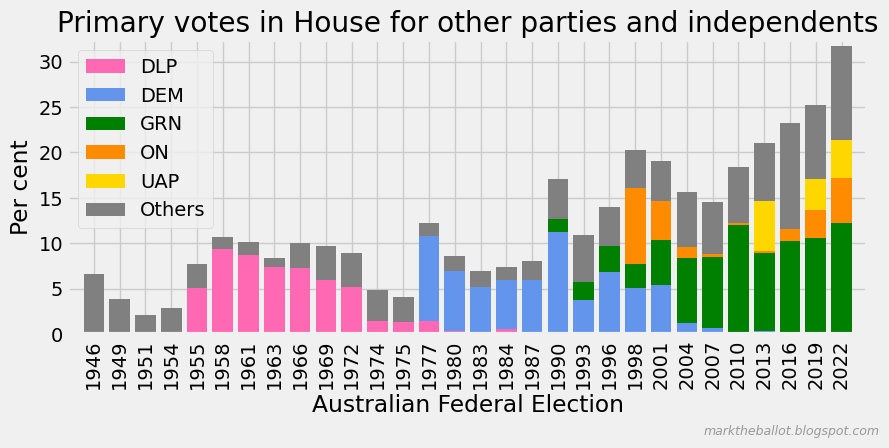

In [45]:
fig, ax = plotting.initiate_plot()
table[e_others].plot.bar(
    stacked=True,
    ax=ax,
    width=0.8,
    color=["hotpink", "cornflowerblue", "green", "darkorange", "gold", "grey"],
)
plotting.finalise_plot(
    ax,
    title="Primary votes in House for other parties and independents",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    show=SHOW,
)

### Mainstream parties

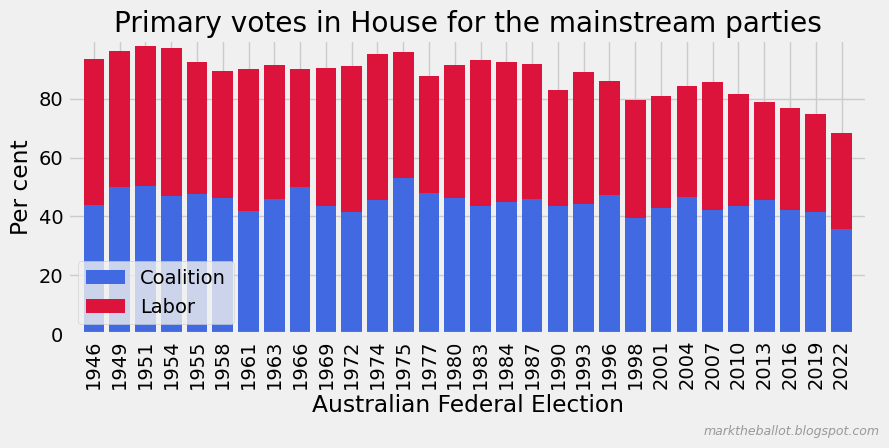

In [46]:
mainstream = table.copy()
mainstream["Coalition"] = mainstream[coalition].sum(axis=1)
mainstream = mainstream.rename(columns={"ALP": "Labor"})
majors = ["Coalition", "Labor"]
fig, ax = plotting.initiate_plot()
mainstream[majors].plot.bar(
    stacked=True, ax=ax, width=0.8, color=[COLOR_COALITION, COLOR_LABOR]
)
plotting.finalise_plot(
    ax,
    title="Primary votes in House for the mainstream parties",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    legend={"loc": "lower left"},
    show=SHOW,
)

### Election cycles

In [47]:
def add_government(from_table, start, ending, to_cycles, colors, markers):
    name = f"{start}-{ending}"
    selection = from_table.index[
        (from_table.index >= start) & (from_table.index <= ending)
    ]
    dates = from_table.loc[selection].Date
    values = from_table.loc[selection].Labor2pp
    if from_table.at[start, "GovtAfter"] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    to_cycles[name] = values

In [48]:
# identify changes of government at an election ...
changes = table["GovtBefore"] != table["GovtAfter"]
change_points = changes[changes].index.values
final = table.index[-1]
if final not in change_points:
    change_points = np.append(change_points, table.index[-1])


# construct separate runs for each government
MARKER_LABOR, MARKER_COALITION = "o", "s"
cycles = pd.DataFrame(index=table.Date)
colors = {}
markers = {}

start = table.index[0]
for ending in change_points:
    add_government(table, start, ending, cycles, colors, markers)
    start = ending

# special case - newly elected government
if table.index[-1] in change_points:
    add_government(table, start, ending, cycles, colors, markers)

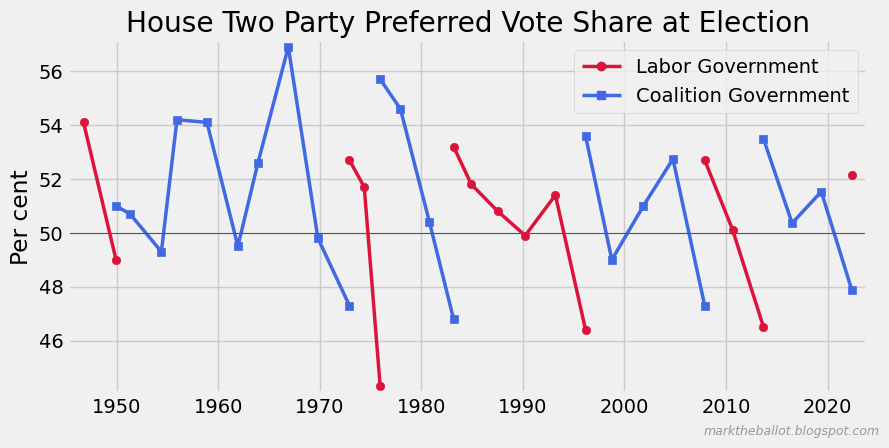

In [49]:
# plot these government cycles
LW = 2.5
fig, ax = plotting.initiate_plot()
for column in cycles.columns:
    cycles[column].plot.line(ax=ax, c=colors[column], linewidth=LW)
    ax.scatter(
        cycles.index, cycles[column], marker=markers[column], color=colors[column]
    )

# custom legend
custom_lines = [
    Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
    Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION),
]
ax.legend(custom_lines, ["Labor Government", "Coalition Government"])

# finalise plot
plotting.finalise_plot(
    ax,
    xlabel=None,
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    title="House Two Party Preferred Vote Share at Election",
    concise_dates=True,
    straighten_tl=True,
    y50=True,
    show=SHOW,
)

### Preference flows

,Green,Other
2004,80.793220,44.195436
2007,79.688341,44.625417
2010,78.843288,41.736056
2013,83.031521,46.688419
2016,81.938946,49.246910
2019,82.208786,43.726802
2022,85.658789,46.365604


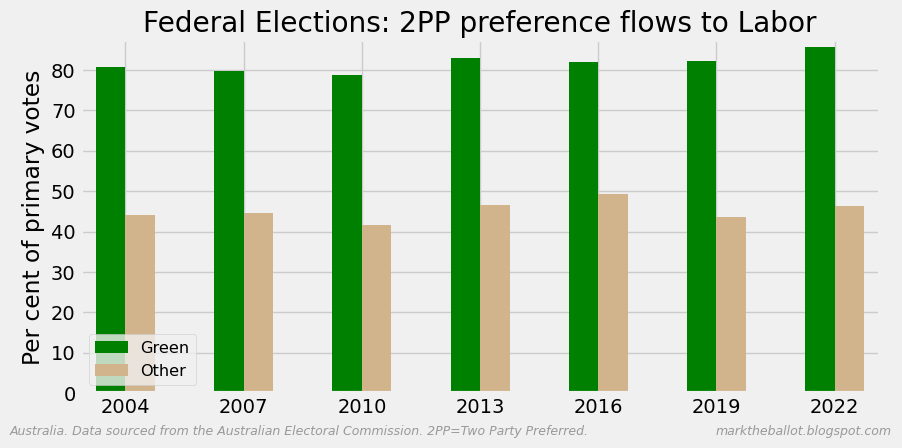

In [88]:
def pflows() -> None:
    """Prefernce flows at recent elections."""

    directory_path = pathlib.Path("../historic-data/preferences")
    files = list(directory_path.glob('*.csv'))
    results = []
    for file in sorted(files):
        year = file.stem.split("-")[0]
        frame = pd.read_csv(
            file, 
            comment="#",
            sep=",",
            header=1,
            index_col=0,
            na_values="-", 
        )
        frame = frame.dropna(how='all', axis=1)
        frame = frame.dropna(how='all', axis=0)
        frame = frame[frame.index.notna()]
        row_sums = (
            frame["Liberal/National Coalition Transfer Votes"]
            + frame["Australian Labor Party Transfer Votes"]
        )
        green = frame.loc["GRN", "Australian Labor Party Transfer Votes"] / row_sums['GRN']
        frame = frame.drop(labels=["GRN", "LP", 'NP'])
        other = (
            frame["Australian Labor Party Transfer Votes"].sum()  / 
            (frame["Australian Labor Party Transfer Votes"].sum() +
             frame["Liberal/National Coalition Transfer Votes"].sum())
        )
        series = pd.Series([green, other], index=["Green", "Other"])
        series.name = year
        results.append(series)

    df = pd.concat(results, axis=1).T * 100
    display(df)
    ax = df.plot(kind="bar", stacked=False, color=["green", "tan"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plotting.finalise_plot(
        ax,
        title="Federal Elections: 2PP preference flows to Labor",
        ylabel="Per cent of primary votes",
        rfooter=plotting.RFOOTER,
        lfooter="Australia. Data sourced from the Australian Electoral Commission. "
        + "2PP=Two Party Preferred. ",
        legend={"loc": "lower left", "fontsize": "small"},
        show=SHOW,
    )


pflows()

## The End

In [50]:
%load_ext watermark
%watermark --python --machine --conda --iversion --watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.32.0

conda environment: pymc

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

matplotlib: 3.10.0
pandas    : 2.2.3
numpy     : 1.26.4

Watermark: 2.5.0



In [51]:
print("It is done")

It is done
